In [1]:
import math
import random
import numpy as np
import copy
import itertools
import time
import matplotlib.pyplot as plt

In [2]:
class LocalSearch:
    def __init__(self, demand_nodes, facility_nodes, T, demands, distances, max_distance, num_of_facilities):
        '''Initialize the parameters of the local search
        
        '''
        self.demand_nodes = demand_nodes
        self.facility_nodes = facility_nodes
        self.T = T
        self.demands = demands
        self.distances = distances
        self.max_distance = max_distance
        self.num_of_facilities = num_of_facilities
        self.last_move = None
        
        self.best_solution = self.generate_initial_state_random()
        self.best_value = self.solution_value(self.best_solution)
        
        self.curr_solution = None
        self.curr_value = None

    #def is_feasible(self):
    #    pass

    def solution_value(self, solution, verbose=False):
        if verbose:
            print("OOO")
            for i in solution:
                print(i)
            print("OOO")
            
        num_of_nodes = len(self.demand_nodes)
        value = 0
        
        for ind, is_facility in enumerate(solution):
            node = ind % num_of_nodes
            time_period = ind // num_of_nodes
            
            for i in range(num_of_nodes*time_period, num_of_nodes*(time_period+1)):
                if solution[i] and self.distances[i-num_of_nodes*time_period][node] < self.max_distance:
                    value += self.demands[node][time_period]
                    if verbose:
                        print(node, time_period,i, solution[i])
                    break
                    
        return value
        

    def generate_initial_state_random(self):
        solution = [False] * (len(self.demand_nodes)*self.T)
        if num_of_facilities >= len(solution):
            raise Exception("Number of facilities to allocate must be smaller than possible facility places")
        
        inds = random.sample(range(0, len(solution)), self.num_of_facilities)
        for i in inds:
            solution[i] = True
            
        return solution

    def generate_neighbour_1(self, solution):
        '''Completely random facility swap
        '''
        pass
        
    def generate_neighbour_2(self):
        '''Swap two facilities in the same time period
        '''
        pass
        
    def generate_neighbour(self, solution):
        fac = 1 + random.randrange(0, self.num_of_facilities)
        non_fac = 1 + random.randrange(0, len(solution)-self.num_of_facilities)
        self.last_move = []
        
        for i in range(len(solution)):
            if solution[i]:
                fac -= 1
                if fac == 0:
                    solution[i] = False
                    self.last_move.append(i)
            else:
                non_fac -= 1
                if non_fac == 0:
                    solution[i] = True
                    self.last_move.append(i)
                    
            
    
    def invert_last_move(self, solution):
        for i in self.last_move:
            solution[i] = not solution[i]
    
    def local_search(self, max_iters = 10000):
        self.curr_solution = self.generate_initial_state_random()
        self.curr_value = self.solution_value(self.curr_solution)
        
        i = 0
        while i < max_iters:
            self.generate_neighbour(self.curr_solution)
            new_value = self.solution_value(self.curr_solution)

            if new_value > self.curr_value:
                self.curr_value = new_value
            else:
                self.invert_last_move(self.curr_solution)
                

            if new_value > self.best_value:
                self.best_value = new_value
                self.best_solution = copy.deepcopy(self.curr_solution)
                
            i += 1
            
        return self.best_value

In [3]:
def brute_force_DMCLP(demand_nodes, facility_nodes, T, demands, distances, max_distance, num_of_facilities):
    best_value = 0
    num_of_nodes = len(demand_nodes)
    
    for comb in itertools.combinations(range(0, len(demand_nodes)*T), num_of_facilities):
        solution = [False] * (num_of_nodes*T)
        for index in comb:
            solution[index] = True

            
        curr_value = 0        
        for ind, is_facility in enumerate(solution):
            node = ind % num_of_nodes
            time_period = ind // num_of_nodes
            
            for i in range(num_of_nodes*time_period, num_of_nodes*(time_period+1)):
                if solution[i] and distances[i-num_of_nodes*time_period][node] < max_distance:
                    curr_value += demands[node][time_period]
                    break
              
        if curr_value > best_value:
            best_value = curr_value
            
    return best_value

In [4]:
## Toy example
## (0,0), (0, 2), (3, 3), (5,0)

demand_nodes = [0, 1, 2, 3]    # set of demand nodes
facility_nodes = demand_nodes  # set of eligible facility sites
T = 3                          # number of periods

# demand of node i at time period t
demands = [
   [6.52305883, 4.47796663, 9.37052681],
   [2.17060818, 7.02949437, 3.40787859],
   [2.41280871, 6.87973726, 9.08665076],
   [8.86408598, 7.70743075, 7.60847307]
]

# distances between i demand node and j facility
distances = [
    [0.00, 2.00, 4.24, 5.00],
    [2.00, 0.00, 3.16, 5.38],
    [4.24, 3.16, 0.00, 3.61],
    [5.00, 5.38, 3.61, 0.00],
]

max_distance = 4.25         # max distance between demand node and facility
num_of_facilities = 1       # number of facilities to be located in all time periods


# Variables:
facilities_in_period = [
    [False, False, False],
    [False, False, False],
    [False, False, False],
    [False, False, False]
]

covered_nodes_in_period = [
    [False, False, False],
    [False, False, False],
    [False, False, False],
    [False, False, False]
]

In [5]:
ls = LocalSearch(demand_nodes, facility_nodes, T, demands, distances, max_distance, num_of_facilities)
ls.local_search()

29.47352923

In [6]:
brute_force_DMCLP(demand_nodes, facility_nodes, T, demands, distances, max_distance, num_of_facilities)

29.47352923

In [7]:
def test_solution():
    num_of_nodes = random.randrange(5, 13)
    demand_nodes = list(range(num_of_nodes))
    facility_nodes = demand_nodes  
    T = random.randrange(3,6)

    max_demand = 30.0
    demands = (max_demand*np.random.rand(num_of_nodes*T).reshape(num_of_nodes,T)).tolist()
    distances = []
    
    max_coord = 30.0
    
    X = (max_coord * np.random.rand(num_of_nodes)).tolist()
    Y = (max_coord * np.random.rand(num_of_nodes)).tolist()
    for i in range(num_of_nodes):
        curr_dist = []
        for j in range(num_of_nodes):
            curr_dist.append(math.sqrt( (X[i]-X[j])**2 + (Y[i]-Y[j])**2 ))
        distances.append(curr_dist)
        
    max_distance = 8
    num_of_facilities = num_of_nodes//3

    ls = LocalSearch(demand_nodes, facility_nodes, T, demands, distances, max_distance, num_of_facilities)
    ls_value = ls.local_search()
    bf_value = brute_force_DMCLP(demand_nodes, facility_nodes, T, demands, distances, max_distance, num_of_facilities)
    assert(ls_value - bf_value < 0.001)
    
    print("All is good!")
    return ls_value

In [ ]:
for i in range(20):
    test_solution()

In [8]:
def test_solution_on_bigger_set(num_of_nodes = None):
    if num_of_nodes is None:
        num_of_nodes = random.randrange(300, 600)
        
    print("Number of nodes:", num_of_nodes)
    demand_nodes = list(range(num_of_nodes))
    facility_nodes = demand_nodes  
    T = random.randrange(3,6)

    max_demand = 30.0
    demands = (max_demand*np.random.rand(num_of_nodes*T).reshape(num_of_nodes,T)).tolist()
    distances = []
    
    max_coord = 30.0
    
    X = (max_coord * np.random.rand(num_of_nodes)).tolist()
    Y = (max_coord * np.random.rand(num_of_nodes)).tolist()
    for i in range(num_of_nodes):
        curr_dist = []
        for j in range(num_of_nodes):
            curr_dist.append(math.sqrt( (X[i]-X[j])**2 + (Y[i]-Y[j])**2 ))
        distances.append(curr_dist)
        
    max_distance = 8
    num_of_facilities = num_of_nodes//3
    ls = LocalSearch(demand_nodes, facility_nodes, T, demands, distances, max_distance, num_of_facilities)
    ls_value = ls.local_search()
    print("Best value:", ls_value)
    return ls_value

In [ ]:
test_solution_on_bigger_set()

In [10]:
def plot_execution_time_graph():
    algorithm_time = []
    sizes = list(range(100, 600, 100))
    for i in sizes:
        start_time = time.time()
        test_solution_on_bigger_set(i)
        curr_time = time.time() - start_time
        algorithm_time.append(curr_time)
        
    plt.plot(sizes, algorithm_time, 'b')#, label='data_generation')

    plt.xlabel("Number of nodes")
    plt.ylabel("Time of execution")
    plt.legend()
    plt.savefig('execution_time.png')
    plt.show()
    

Number of nodes: 100
Best value: 4487.902670873389
Number of nodes: 200
Best value: 11729.286262751948
Number of nodes: 300
Best value: 22493.167246704725
Number of nodes: 400
Best value: 23876.387911965136
Number of nodes: 500


No handles with labels found to put in legend.


Best value: 29196.757687612542


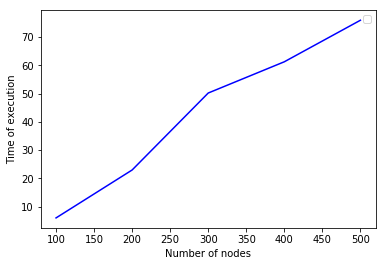

In [11]:
plot_execution_time_graph()